# Temperature and TopK

**Descrição:**
Notebook focado em estratégias de *decoding* para geração de texto em modelos GPT-like, mostrando como **temperature scaling** e **top-k sampling** alteram a aleatoriedade (diversidade) e a coerência do texto gerado. 

**Objetivo:**
Demonstrar, de forma prática, como ajustar os hiperparâmetros **temperature** e **top_k** para controlar o comportamento do modelo na etapa de inferência — indo de uma geração determinística (greedy) para uma geração probabilística com maior variedade.

**Funcionamento:**
1. Define a configuração do modelo (mesma base do notebook de arquitetura, com *context_length* reduzido) e carrega o modelo previamente treinado.
2. Mostra o comportamento determinístico quando o próximo token é escolhido de forma “gulosa” (sempre o mais provável).
3. Introduz uma função de geração que aplica:
   - **Top-k sampling**: restringe a amostragem aos *k* tokens mais prováveis;
   - **Temperature scaling**: “achata” ou “afunila” a distribuição de probabilidade antes de amostrar. 
4. Executa experimentos comparando diferentes temperaturas (ex.: 0.1, 1, 5) e observa como a distribuição muda (mais conservadora vs. mais criativa), repetindo a geração do próximo token para evidenciar a variabilidade.


![Bloco transformer](../../imagens/cap05/02_temperature_and_topk.png)

In [1]:
from collections.abc import Sequence
from dataclasses import dataclass
from typing import Any

import matplotlib.pyplot as plt
import tiktoken
import torch

from build_llm.gpt import GPTModel
from build_llm.util import generate_text_simple, text_to_token_ids, token_ids_to_text

## Configuração do modelo

As mesmas utilizadas no notebook [01 - LLM architecture](./01%20-%20LLM%20architecture.ipynb)
**exceto** pela janela de contexto (context_length) que foi reduziada para 256 (anteriormente era 1024)

In [2]:
GPT_CONFIG_124M: dict[str, Any] = {
    "vocab_size": 50257,  # Tamanho do vocabulário
    "context_length": 256,  # Comprimento do contexto
    "emb_dim": 768,  # Dimensão do embedding
    "n_heads": 12,  # Número de cabeças de atenção
    "n_layers": 12,  # Número de camadas
    "drop_rate": 0.1,  # Taxa de dropout
    "qkv_bias": False,  # Viés em Query-Key-Value (QKV)
}

In [3]:
def get_device() -> torch.device:
    """
    Retorna o device apropriado (CUDA se disponível, caso contrário CPU).
    """
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Carrega o modelo 
Treinado no notebook [01 - GPT Training](./01%20-%20GPT%20Training.ipynb)

In [4]:
# Inicializa o tokenizer (encoding compatível com GPT-2)
tokenizer = tiktoken.get_encoding("gpt2")

model = GPTModel(GPT_CONFIG_124M)
device = get_device()
print("Device:", device)

model.load_state_dict(
    torch.load("../../models/my_gpt.pth", map_location=device, weights_only=True)
)
model.eval()

Device: cpu


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

### Aqui o modelo sempre gera o mesmo resultado (mesmo que executado múltiplas vezes)

In [5]:
# Gera texto a partir de um prompt inicial
prompt = "Quando voltámos, á noite, viemos por alli"
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(prompt, tokenizer).to(device),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"],
)

# Decodifica e imprime o resultado
output_text = token_ids_to_text(token_ids, tokenizer)
print(f"Texto de saída:\n{output_text}")

Texto de saída:
Quando voltámos, á noite, viemos por allição,
olhos de tão


In [6]:
# Gera texto a partir de um prompt inicial
prompt = "Quando voltámos, á noite, viemos por alli"
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(prompt, tokenizer).to(device),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"],
)

# Decodifica e imprime o resultado
output_text = token_ids_to_text(token_ids, tokenizer)
print(f"Texto de saída:\n{output_text}")

Texto de saída:
Quando voltámos, á noite, viemos por allição,
olhos de tão


# Função final para gerar a partir do TopK e Temperatura

In [7]:
def generate(
    model,
    idx,
    max_new_tokens,
    context_size,
    temperature: float = 0.0,
    top_k=None,
    eos_id=None,
):
    """
    Gera novos tokens a partir de um modelo autoregressivo.

    Parâmetros:
    ----------
    model
        Modelo que recebe `idx_cond` e retorna logits no formato (batch, seq_len, vocab).
    idx
        Tensor com os índices atuais (batch_size, seq_len).
    max_new_tokens
        Número máximo de novos tokens a serem gerados.
    context_size
        Tamanho do contexto (janela) usado a cada passo.
    temperature : float, default = 0.0
        Temperatura para amostragem. Se 0.0, usa greedy (argmax).
    top_k : int | None, default = None
        Se definido, aplica filtragem top-k antes de amostrar.
    eos_id : int | None, default = None
        Id do token de fim de sequência. Se encontrado, encerra a geração.

    Retorno:
    -------
    Tensor
        Sequência final com os tokens gerados (batch_size, seq_len + tokens_gerados).
    """
    # O laço é o mesmo de antes: obtém os logits e considera apenas o último passo de tempo
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]

        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :]

        # Novo: filtra os logits usando amostragem top-k
        if top_k is not None:
            # Mantém apenas os top_k maiores valores
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val,
                torch.tensor(float("-inf"), device=logits.device),
                logits,
            )

        # Novo: aplica escalonamento por temperatura
        if temperature > 0.0:
            logits = logits / temperature

            # Novo (não está no livro): dica de estabilidade numérica para obter resultados equivalentes no device MPS
            # Subtrai o máximo por linha antes do softmax
            logits = logits - logits.max(dim=-1, keepdim=True).values

            # Aplica softmax para obter probabilidades
            probs = torch.softmax(logits, dim=-1)  # (batch_size, vocab_size)

            # Amostra da distribuição
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)
        else:
            # Caso contrário, como antes: pega o índice com o maior valor de logits (greedy)
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        # Para a geração cedo se o token de fim de sequência for encontrado e eos_id tiver sido especificado
        if eos_id is not None and (idx_next == eos_id).all():
            break

        # Como antes: concatena o índice amostrado à sequência em execução
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens + 1)

    return idx

### O texto abaixo já é distinto dos anteriores

In [8]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Quando voltámos, á noite, viemos por alli", tokenizer).to(
        device
    ),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=10,
    temperature=1.5,
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Quando voltámos, á noite, viemos por alli um modo,...

Este,


## Verificando a influência do TOP-K e da temperatura na geração do próximo token

In [9]:
@dataclass(frozen=True)
class TopKDistribution:
    """
    Estrutura para armazenar a distribuição top-k do próximo token.

    Atributos:
    ---------
    token_ids : torch.Tensor
        Tensor (top_k,) com os ids dos tokens no vocabulário.
    probs : torch.Tensor
        Tensor (top_k,) com as probabilidades correspondentes.
    tokens : List[str]
        Lista (top_k,) com a representação textual de cada token.
    temperature : float
        Temperatura usada para escalonar os logits.
    top_k : int
        Valor de k usado na filtragem top-k.
    """

    token_ids: torch.Tensor
    probs: torch.Tensor
    tokens: list[str]
    temperature: float
    top_k: int


def _apply_top_k_filter(logits: torch.Tensor, top_k: int) -> torch.Tensor:
    """
    Aplica filtragem top-k em logits 2D (batch, vocab).

    Mantém apenas os top_k maiores logits por linha e zera (via -inf) o resto.
    """
    if top_k <= 0:
        raise ValueError("top_k deve ser um inteiro positivo (> 0).")

    top_logits, _ = torch.topk(logits, k=top_k, dim=-1)
    min_val = top_logits[:, -1].unsqueeze(-1)  # (batch, 1)
    filtered = torch.where(
        logits < min_val,
        torch.tensor(float("-inf"), device=logits.device, dtype=logits.dtype),
        logits,
    )
    return filtered


@torch.no_grad()
def next_token_topk_distributions(
    model,
    idx: torch.Tensor,
    context_size: int,
    temperatures: Sequence[float] = (1.0, 0.1, 5.0),
    top_k: int = 25,
    tokenizer=None,
) -> dict[float, TopKDistribution]:
    """
    Calcula a distribuição top-k do *próximo token* para várias temperaturas.

    Parâmetros:
    ----------
    model
        Modelo autoregressivo: recebe idx_cond e retorna logits (batch, seq, vocab).
    idx : torch.Tensor
        Tensor (batch, seq_len) com os ids dos tokens de contexto.
        Observação: para o gráfico, o batch deve ser 1.
    context_size : int
        Tamanho máximo da janela de contexto usada (recorta idx no final).
    temperatures : Sequence[float]
        Lista/tupla de temperaturas a comparar (ex.: [1, 0.1, 5]).
        Recomendação: evitar 0 aqui; 0 é "greedy", não uma distribuição.
    top_k : int
        Top-k para filtrar logits antes do softmax.
    tokenizer : opcional
        Tokenizer com decode(list[int]) ou decode(int)/id->string.
        Se None, o campo `tokens` vira strings com os ids.

    Retorno:
    -------
    Dict[float, TopKDistribution]
        Um dicionário {temperatura: distribuição_topk}.
    """
    if idx.dim() != 2:
        raise ValueError("idx deve ter shape (batch, seq_len).")
    if idx.size(0) != 1:
        raise ValueError("Para plotar de forma legível, use batch_size=1.")
    if top_k is None:
        raise ValueError("top_k precisa ser definido para esta função.")

    # 1) logits do último passo
    idx_cond = idx[:, -context_size:]
    logits = model(idx_cond)  # (1, seq, vocab)
    logits = logits[:, -1, :]  # (1, vocab)

    # 2) top-k filter (uma vez) – depois cada temperatura só reescala
    logits_topk = _apply_top_k_filter(logits, top_k=top_k)

    results: dict[float, TopKDistribution] = {}

    for t in temperatures:
        if t <= 0:
            raise ValueError(f"Temperatura deve ser > 0. Recebido: {t}")

        # 3) temperature scaling
        scaled = logits_topk / float(t)

        # dica de estabilidade numérica
        scaled = scaled - scaled.max(dim=-1, keepdim=True).values

        # 4) probs
        probs = torch.softmax(scaled, dim=-1)  # (1, vocab)

        # 5) extrai top_k final (já deve coincidir com o top_k filtrado, mas garantimos)
        p_top, ids_top = torch.topk(probs, k=top_k, dim=-1)
        p_top = p_top.squeeze(0).detach().cpu()
        ids_top = ids_top.squeeze(0).detach().cpu()

        if tokenizer is None:
            tokens = [str(int(i)) for i in ids_top.tolist()]
        else:
            # tenta caminhos comuns de decode
            tokens = []
            for i in ids_top.tolist():
                try:
                    tokens.append(tokenizer.decode([int(i)]))
                except Exception:
                    try:
                        tokens.append(tokenizer.decode(int(i)))
                    except Exception:
                        tokens.append(str(int(i)))

        results[float(t)] = TopKDistribution(
            token_ids=ids_top,
            probs=p_top,
            tokens=tokens,
            temperature=float(t),
            top_k=int(top_k),
        )

    return results

In [10]:
def plot_topk_temperature_comparison(
    dists: dict[float, TopKDistribution],
    title: str = "Distribuição top-k do próximo token por temperatura",
    rotate_xticks: int = 45,
) -> None:
    """
    Plota barras agrupadas comparando as probabilidades top-k entre temperaturas.

    Observação importante:
    - Cada temperatura pode ter um top-k (lista de tokens) diferente.
      Para ficar “tipo o anexo”, usamos a união dos tokens e colocamos 0 onde não aparecer.
    """
    if not dists:
        raise ValueError("dists está vazio.")

    temps = sorted(dists.keys())
    # União de tokens (na ordem: usa a ordem da menor temperatura como base e adiciona o resto)
    base_tokens = dists[temps[0]].tokens
    token_set = list(base_tokens)
    seen = set(base_tokens)

    for t in temps[1:]:
        for tok in dists[t].tokens:
            if tok not in seen:
                token_set.append(tok)
                seen.add(tok)

    # matriz de probs: (n_temps, n_tokens_union)
    prob_mat = []
    for t in temps:
        tok2p = {
            tok: float(p)
            for tok, p in zip(dists[t].tokens, dists[t].probs.tolist(), strict=False)
        }
        prob_mat.append([tok2p.get(tok, 0.0) for tok in token_set])

    n_temps = len(temps)
    n_tokens = len(token_set)

    x = torch.arange(n_tokens).numpy()
    width = 0.8 / max(n_temps, 1)

    plt.figure(figsize=(10, 4))
    for i, t in enumerate(temps):
        offset = (i - (n_temps - 1) / 2) * width
        plt.bar(x + offset, prob_mat[i], width=width, label=f"Temperature = {t}")

    plt.title(title)
    plt.ylabel("Probability")
    plt.xticks(x, token_set, rotation=rotate_xticks, ha="right")
    plt.legend()
    plt.tight_layout()
    plt.show()

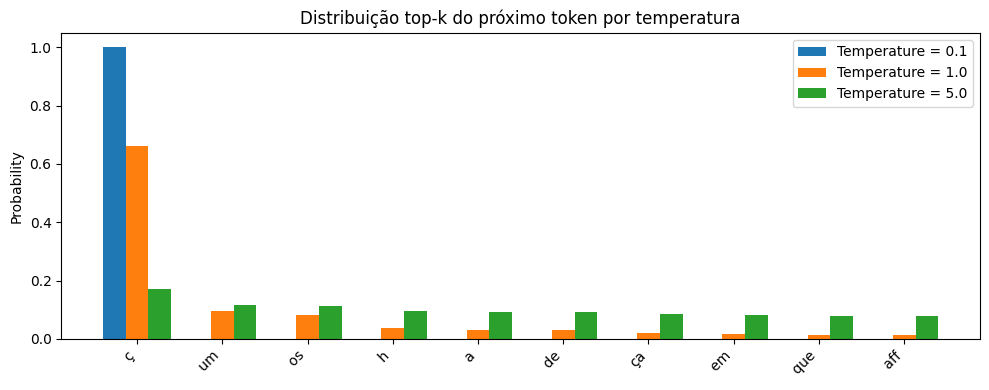

In [14]:
idx = text_to_token_ids("Quando voltámos, á noite, viemos por alli", tokenizer).to(
    device
)
dists = next_token_topk_distributions(
    model=model,
    idx=idx,
    context_size=GPT_CONFIG_124M["context_length"],
    temperatures=[1, 0.1, 5],  # Original, higher confidence, and lower confidence
    top_k=10,
    tokenizer=tokenizer,
)
plot_topk_temperature_comparison(dists)

In [12]:
for t, dist in dists.items():
    print(f"\nTemperature={t}")
    for tok, p in list(zip(dist.tokens, dist.probs.tolist(), strict=False))[:10]:
        print(f"{tok!r}: {p:.4f}")


Temperature=1.0
'ç': 0.6004
' um': 0.0865
' os': 0.0749
' h': 0.0332
' a': 0.0273
' de': 0.0272
'ça': 0.0191
' em': 0.0149
' que': 0.0125
' aff': 0.0122

Temperature=0.1
'ç': 1.0000
' um': 0.0000
' os': 0.0000
' h': 0.0000
' a': 0.0000
' de': 0.0000
'ça': 0.0000
' em': 0.0000
' que': 0.0000
' aff': 0.0000

Temperature=5.0
'ç': 0.0980
' um': 0.0666
' os': 0.0647
' h': 0.0550
' a': 0.0528
' de': 0.0528
'ça': 0.0492
' em': 0.0468
' que': 0.0452
' aff': 0.0450


### Gerando o próximo token 5 vezes com a temperatura em 0.1

In [17]:
for i in range(5):
    print(i)
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(
            "Quando voltámos, á noite, viemos por alli", tokenizer
        ).to(device),
        max_new_tokens=1,
        context_size=GPT_CONFIG_124M["context_length"],
        top_k=10,
        temperature=0.1,
    )

    print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

0
Output text:
 Quando voltámos, á noite, viemos por alliç
1
Output text:
 Quando voltámos, á noite, viemos por alliç
2
Output text:
 Quando voltámos, á noite, viemos por alliç
3
Output text:
 Quando voltámos, á noite, viemos por alliç
4
Output text:
 Quando voltámos, á noite, viemos por alliç


### Gerando o próximo token 5 vezes com a temperatura em 1

In [16]:
for i in range(5):
    print(i)
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(
            "Quando voltámos, á noite, viemos por alli", tokenizer
        ).to(device),
        max_new_tokens=1,
        context_size=GPT_CONFIG_124M["context_length"],
        top_k=10,
        temperature=1,
    )

    print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

0
Output text:
 Quando voltámos, á noite, viemos por alli de
1
Output text:
 Quando voltámos, á noite, viemos por alliç
2
Output text:
 Quando voltámos, á noite, viemos por alli um
3
Output text:
 Quando voltámos, á noite, viemos por alliç
4
Output text:
 Quando voltámos, á noite, viemos por alliç


### Gerando o próximo token 5 vezes com a temperatura em 5

In [15]:
for i in range(5):
    print(i)
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(
            "Quando voltámos, á noite, viemos por alli", tokenizer
        ).to(device),
        max_new_tokens=1,
        context_size=GPT_CONFIG_124M["context_length"],
        top_k=10,
        temperature=5,
    )

    print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

0
Output text:
 Quando voltámos, á noite, viemos por alli um
1
Output text:
 Quando voltámos, á noite, viemos por alli h
2
Output text:
 Quando voltámos, á noite, viemos por alliça
3
Output text:
 Quando voltámos, á noite, viemos por alli um
4
Output text:
 Quando voltámos, á noite, viemos por alliç
